In [1]:
.libPaths("/u/project/eeskin2//k8688933/R/x86_64-pc-linux-gnu-library//3.5")

In [2]:
library(data.table)
library(ggpubr)
library(tidyr)
library(dplyr)
library(Cairo)

Loading required package: ggplot2
Loading required package: magrittr

Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
setwd("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary")

##### RV eGenes

In [4]:
indiv.with.rare.var <- lapply(dir("indiv.with.rare.var.idx.rv.egenes.only/", 
                                  full.names = T), 
                              function(x) {try(fread(x), T)})
rare.z <- lapply(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt",
                     full.names = T), 
                 function(x) {try(fread(x), T)})

In [5]:
names(indiv.with.rare.var) <- tstrsplit(dir("indiv.with.rare.var.idx.rv.egenes.only/"), "\\.")[[7]]
names(rare.z) <- tstrsplit(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt"), "\\.")[[8]]

In [6]:
get.outliers.per.tissue <- function(tpm, threshold = 2) {
    sample.tpm = tpm
    if (!any(class(sample.tpm) == "data.frame")) {
#       result = rbind(result, rep(NA, ncol(result)))
#       next()
        return()
    }
#     sample.rare = rare.idx[[tissue]]
#     selected.gene.idx = match(sample.tpm$gene, sample.rare$gene)
    selected.gene = sample.tpm$gene
    sample.tpm = sample.tpm[, -1]
#     sample.rare = sample.rare[selected.gene.idx, -1]
    sample.tpm = t(scale(t(sample.tpm)))

    outliers.idx = abs(sample.tpm) > threshold
#     rare.outliers.idx = outliers.idx & sample.rare
#     common.outliers.idx = outliers.idx & (!sample.rare)
#     rare.controls.idx = (!outliers.idx) & sample.rare
#     common.controls.idx = (!outliers.idx) & (!sample.rare)

    num.total.outliers = rowSums(outliers.idx)
    num.total.controls = rowSums(!outliers.idx)
#     num.common.outliers = rowSums(common.outliers.idx)
#     num.common.controls = rowSums(common.controls.idx)
#     num.rare.outliers = rowSums(rare.outliers.idx)
#     num.rare.controls = rowSums(rare.controls.idx)
#     prop.rare.outliers = num.rare.outliers / num.total.outliers

  return(num.total.outliers)
}

In [7]:
tmp = lapply(rare.z, get.outliers.per.tissue)

In [8]:
lapply(tmp, function(x) sum(x > 0) / length(x))

$Adipose_Subcutaneous
[1] 1

$Adipose_Visceral_Omentum
[1] 1

$Adrenal_Gland
[1] 1

$Artery_Aorta
[1] 1

$Artery_Coronary
[1] 1

$Artery_Tibial
[1] 1

$Brain_Amygdala
[1] NaN

$Brain_Anterior_cingulate_cortex_BA24
[1] NaN

$Brain_Caudate_basal_ganglia
[1] 1

$Brain_Cerebellar_Hemisphere
[1] 1

$Brain_Cerebellum
[1] 1

$Brain_Cortex
[1] 1

$Brain_Frontal_Cortex_BA9
[1] 1

$Brain_Hippocampus
[1] 1

$Brain_Hypothalamus
[1] 1

$Brain_Nucleus_accumbens_basal_ganglia
[1] 1

$Brain_Putamen_basal_ganglia
[1] NaN

$`Brain_Spinal_cord_cervical_c-1`
[1] NaN

$Brain_Substantia_nigra
[1] NaN

$Breast_Mammary_Tissue
[1] 1

$Cells_Cultured_fibroblasts
[1] 1

$`Cells_EBV-transformed_lymphocytes`
[1] NaN

$Colon_Sigmoid
[1] 1

$Colon_Transverse
[1] 1

$Esophagus_Gastroesophageal_Junction
[1] 1

$Esophagus_Mucosa
[1] 1

$Esophagus_Muscularis
[1] 1

$Heart_Atrial_Appendage
[1] 1

$Heart_Left_Ventricle
[1] 1

$Kidney_Cortex
[1] NaN

$Liver
[1] 1

$Lung
[1] 1

$Minor_Salivary_Gland
[1] NaN

$Muscle_Skeletal
[1] 1

$Nerve_Tibial
[1] 1

$Ovary
[1] NaN

$Pancreas
[1] 1

$Pituitary
[1] 1

$Prostate
[1] 1

$Skin_Not_Sun_Exposed_Suprapubic
[1] 1

$Skin_Sun_Exposed_Lower_leg
[1] 1

$Small_Intestine_Terminal_Ileum
[1] 1

$Spleen
[1] 1

$Stomach
[1] 1

$Testis
[1] 1

$Thyroid
[1] 1

$Uterus
[1] NaN

$Vagina
[1] NaN

$Whole_Blood
[1] 1

In [9]:
compute.outliers.enrichment <- function(sample.tpm, sample.rare) {
        if (!any(class(sample.tpm) == "data.frame")) {
          return()
        }
        # not compute for each gene, but for the whole dataset
        result = data.frame()
        selected.gene.idx = match(sample.tpm$gene, sample.rare$gene)
        sample.tpm = sample.tpm[, -1]
        sample.rare = sample.rare[selected.gene.idx, -1]
        sample.tpm = t(scale(t(sample.tpm)))
        for (threshold in seq(1, 10)) {
          outliers.idx = abs(sample.tpm) > threshold
          rare.outliers.idx = outliers.idx & sample.rare
          common.outliers.idx = outliers.idx & (!sample.rare)
          rare.controls.idx = (!outliers.idx) & sample.rare
          common.controls.idx = (!outliers.idx) & (!sample.rare)
          num.total.outliers = sum(outliers.idx)
          num.total.controls = sum(!outliers.idx)
          num.common.outliers = sum(common.outliers.idx)
          num.common.controls = sum(common.controls.idx)
          num.rare.outliers = sum(rare.outliers.idx)
          num.rare.controls = sum(rare.controls.idx)
          relative.risk <- (num.rare.outliers / num.total.outliers) / (num.rare.controls / num.total.controls)
          log.se <- sqrt(1/num.rare.outliers - 1/num.total.outliers + 1/num.rare.controls - 1/num.total.controls)
          max.ci <- relative.risk * exp(1.96 * log.se)
          min.ci <- relative.risk * exp(-1.96 * log.se)
          pval <- pnorm(log(relative.risk) / log.se, lower.tail = F)
          result = rbind(result, c(num.total.outliers, num.total.controls, num.rare.outliers, num.rare.controls, 
                                   num.common.outliers, num.common.controls, relative.risk, log.se, max.ci, min.ci, 
                                   pval, threshold))
          
        }
        colnames(result) = c("total.outliers", "total.controls", "rare.outliers", "rare.controls", "common.outliers", 
                             "common.controls", "relative.risk", "log.se", "max.ci", "min.ci", "pval", "threshold")
        return(result)
      }

In [10]:
outliers.enrichment = vector("list", length(indiv.with.rare.var))
names(outliers.enrichment) <- names(indiv.with.rare.var)
for (tissue in names(indiv.with.rare.var)) {
outliers.enrichment[[tissue]] = compute.outliers.enrichment(rare.z[[tissue]], 
                                                            indiv.with.rare.var[[tissue]])
}

In [11]:
saveRDS(outliers.enrichment, "/u/project//eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/outliers.enrichment.rv.egene.only.rds")

##### Non-RV eGenes

In [12]:
indiv.with.rare.var <- lapply(dir("indiv.with.rare.var.idx.non.rv.egenes.only/", 
                                  full.names = T), 
                              function(x) {try(fread(x), T)})
rare.z <- lapply(dir("log2.standardized.corrected.tpm.non.rv.egenes.only/",
                     full.names = T), 
                 function(x) {try(fread(x), T)})

In [13]:
names(indiv.with.rare.var) <- tstrsplit(dir("indiv.with.rare.var.idx.non.rv.egenes.only/"), "\\.")[[8]]
names(rare.z) <- tstrsplit(dir("log2.standardized.corrected.tpm.non.rv.egenes.only/"), "\\.")[[8]]

In [14]:
tmp = lapply(rare.z, get.outliers.per.tissue)

In [15]:
lapply(tmp, function(x) sum(x > 0) / length(x))

$Adipose_Subcutaneous
[1] 1

$Adipose_Visceral_Omentum
[1] 1

$Adrenal_Gland
[1] 0.9999131

$Artery_Aorta
[1] 1

$Artery_Coronary
[1] 0.9998735

$Artery_Tibial
[1] 1

$Brain_Amygdala
[1] 0.9997421

$Brain_Anterior_cingulate_cortex_BA24
[1] 0.9999575

$Brain_Caudate_basal_ganglia
[1] 1

$Brain_Cerebellar_Hemisphere
[1] 1

$Brain_Cerebellum
[1] 0.9999183

$Brain_Cortex
[1] 0.9999583

$Brain_Frontal_Cortex_BA9
[1] 1

$Brain_Hippocampus
[1] 0.9999576

$Brain_Hypothalamus
[1] 0.9999175

$Brain_Nucleus_accumbens_basal_ganglia
[1] 0.9999584

$Brain_Putamen_basal_ganglia
[1] 0.9999132

$`Brain_Spinal_cord_cervical_c-1`
[1] 0.9997904

$Brain_Substantia_nigra
[1] 0.9996131

$Breast_Mammary_Tissue
[1] 1

$Cells_Cultured_fibroblasts
[1] 0.9999498

$`Cells_EBV-transformed_lymphocytes`
[1] 0.9997275

$Colon_Sigmoid
[1] 1

$Colon_Transverse
[1] 1

$Esophagus_Gastroesophageal_Junction
[1] 1

$Esophagus_Mucosa
[1] 1

$Esophagus_Muscularis
[1] 1

$Heart_Atrial_Appendage
[1] 1

$Heart_Left_Ventricle
[1] 1

$Kidney_Cortex
[1] 0.9932986

$Liver
[1] 1

$Lung
[1] 1

$Minor_Salivary_Gland
[1] 0.9998788

$Muscle_Skeletal
[1] 1

$Nerve_Tibial
[1] 1

$Ovary
[1] 0.9999591

$Pancreas
[1] 1

$Pituitary
[1] 1

$Prostate
[1] 0.999922

$Skin_Not_Sun_Exposed_Suprapubic
[1] 1

$Skin_Sun_Exposed_Lower_leg
[1] 1

$Small_Intestine_Terminal_Ileum
[1] 0.9999606

$Spleen
[1] 0.9999594

$Stomach
[1] 1

$Testis
[1] 1

$Thyroid
[1] 1

$Uterus
[1] 0.9997125

$Vagina
[1] 0.9998797

$Whole_Blood
[1] 1

In [16]:
outliers.enrichment = vector("list", length(indiv.with.rare.var))
names(outliers.enrichment) <- names(indiv.with.rare.var)
for (tissue in names(indiv.with.rare.var)) {
outliers.enrichment[[tissue]] = compute.outliers.enrichment(rare.z[[tissue]], 
                                                            indiv.with.rare.var[[tissue]])
}

In [17]:
saveRDS(outliers.enrichment, "/u/project//eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/outliers.enrichment.non.rv.egene.only.rds")

### Enrichment in each tissue

In [20]:
rv.outliers.enrichment = readRDS("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/outliers.enrichment.rv.egene.only.rds")
rv.df = rbindlist(lapply(rv.outliers.enrichment, function(x) x[2, ]))
rv.df$tissue = names(rv.outliers.enrichment)

In [21]:
outliers.enrichment = readRDS("/u/project//eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/outliers.enrichment.non.rv.egene.only.rds")
non.rv.df = rbindlist(lapply(outliers.enrichment, function(x) x[2, ]))
non.rv.df$tissue = names(outliers.enrichment)

In [22]:
non.rv.df %>% filter(tissue %in% rv.df$tissue) -> non.rv.df

In [23]:
rv.df$type = "RV eGenes"
non.rv.df$type = "Non-RV eGenes"
df = rbind(rv.df, non.rv.df)

png 
  2

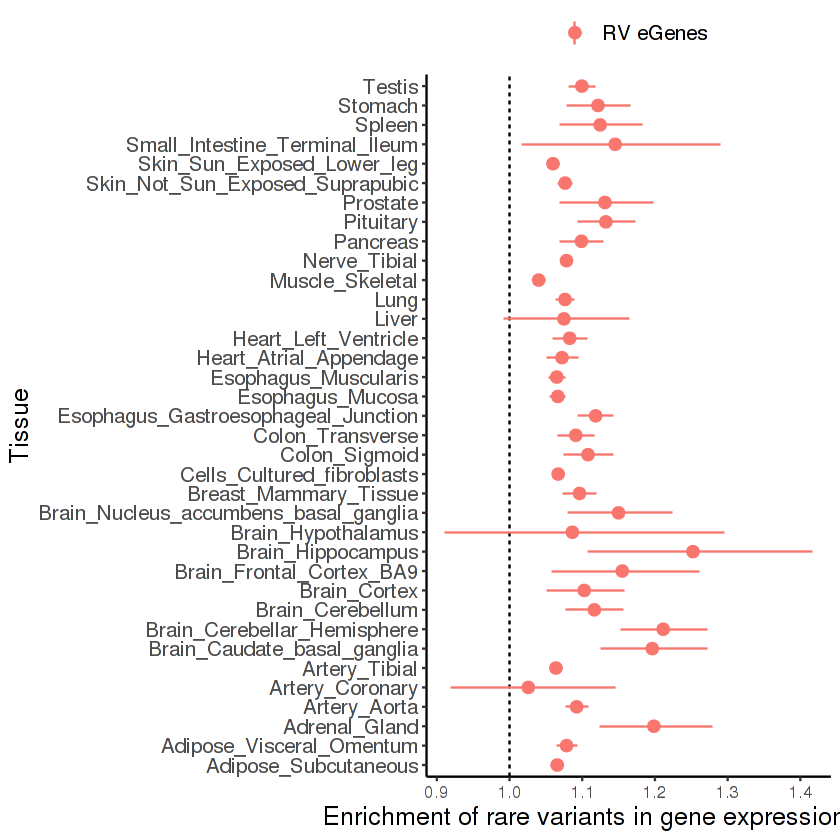

In [24]:
CairoPDF("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/rare.variant.enrichment.pdf", 
       width = 12, height = 14)
p = ggplot(df[1:36, ], aes(x = tissue, y = relative.risk)) +
theme_bw() + ylab('Enrichment of rare variants in gene expression outliers') + xlab("Tissue") +
geom_abline(intercept = 1, slope = 0, linetype = "dashed") + #ylim(0.95, 1.15) +
geom_pointrange(aes(x = tissue, ymin = min.ci, ymax = max.ci, colour=type), 
               position = position_dodge(0.6)) + labs(color="") +
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(), legend.position = "top",
      axis.text.x = element_text(size = 10), text = element_text(size = 15),
      axis.line = element_line(colour = "black")) + coord_flip() #+ 
# geom_text(aes(label=formatC(pval, digits = 2, format = "e")), vjust = -1.5)
print(p)
dev.off()

png 
  2

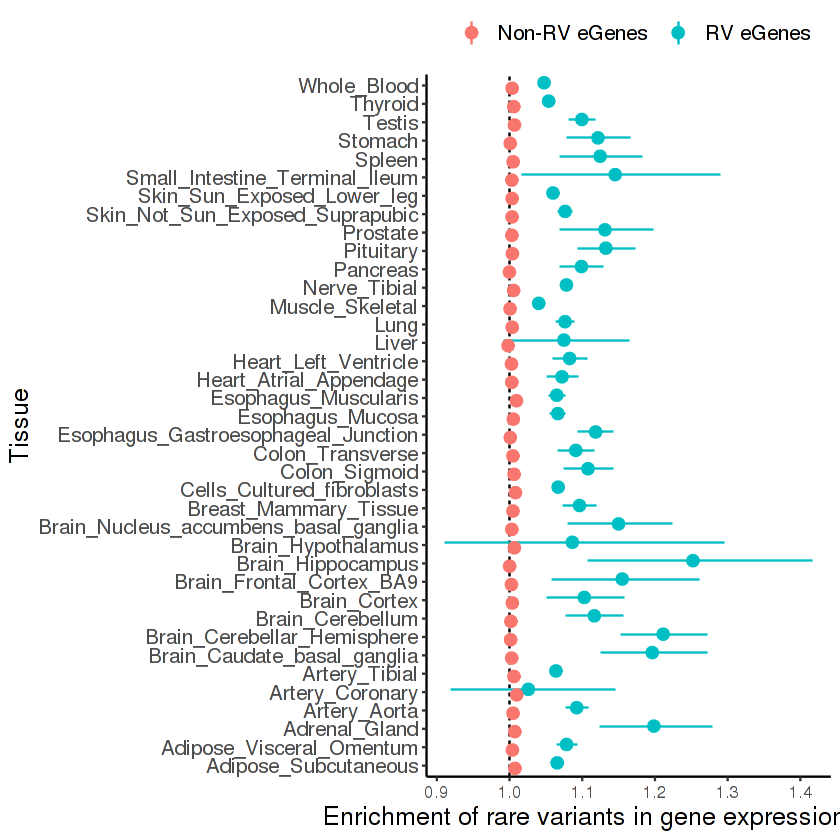

In [25]:
CairoPDF("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/rare.variant.enrichment.pdf", 
       width = 12, height = 14)
p = ggplot(df, aes(x = tissue, y = relative.risk)) +
theme_bw() + ylab('Enrichment of rare variants in gene expression outliers') + xlab("Tissue") +
geom_abline(intercept = 1, slope = 0, linetype = "dashed") + #ylim(0.95, 1.15) +
geom_pointrange(aes(x = tissue, ymin = min.ci, ymax = max.ci, colour=type), 
               position = position_dodge(0.6)) + labs(color="") +
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(), legend.position = "top",
      axis.text.x = element_text(size = 10), text = element_text(size = 15),
      axis.line = element_line(colour = "black")) + coord_flip() #+ 
# geom_text(aes(label=formatC(pval, digits = 2, format = "e")), vjust = -1.5)
print(p)
dev.off()

### Enrichment by Z-score threshold

In [26]:
summary.outliers.enrichment.cv = Reduce("+", lapply(outliers.enrichment, function(x) {x[, 1:6]}))
summary.outliers.enrichment.rv = Reduce("+", lapply(rv.outliers.enrichment, function(x) {x[, 1:6]}))
summary.outliers.enrichment.cv$threshold = seq(1, 10)
summary.outliers.enrichment.rv$threshold = seq(1, 10)
summary.outliers.enrichment.cv$type = "Non-RV eGenes"
summary.outliers.enrichment.rv$type = "RV eGenes"

In [27]:
summary.outliers.enrichment = rbind(summary.outliers.enrichment.cv,
                                   summary.outliers.enrichment.rv)

In [28]:
summary.outliers.enrichment$log.se = sqrt(1 / summary.outliers.enrichment$rare.outliers -
                                          1 / summary.outliers.enrichment$total.outliers +
                                          1 / summary.outliers.enrichment$rare.controls -
                                          1 / summary.outliers.enrichment$total.controls)
summary.outliers.enrichment$relative.risk = 
(summary.outliers.enrichment$rare.outliers / summary.outliers.enrichment$total.outliers) /
(summary.outliers.enrichment$rare.controls / summary.outliers.enrichment$total.controls)
summary.outliers.enrichment$max.ci = 
summary.outliers.enrichment$relative.risk * exp(1.96 * summary.outliers.enrichment$log.se)
summary.outliers.enrichment$min.ci = 
summary.outliers.enrichment$relative.risk * exp(-1.96 * summary.outliers.enrichment$log.se)
summary.outliers.enrichment$pval = 
pnorm(log(summary.outliers.enrichment$relative.risk) / summary.outliers.enrichment$log.se, lower.tail = F)

png 
  2

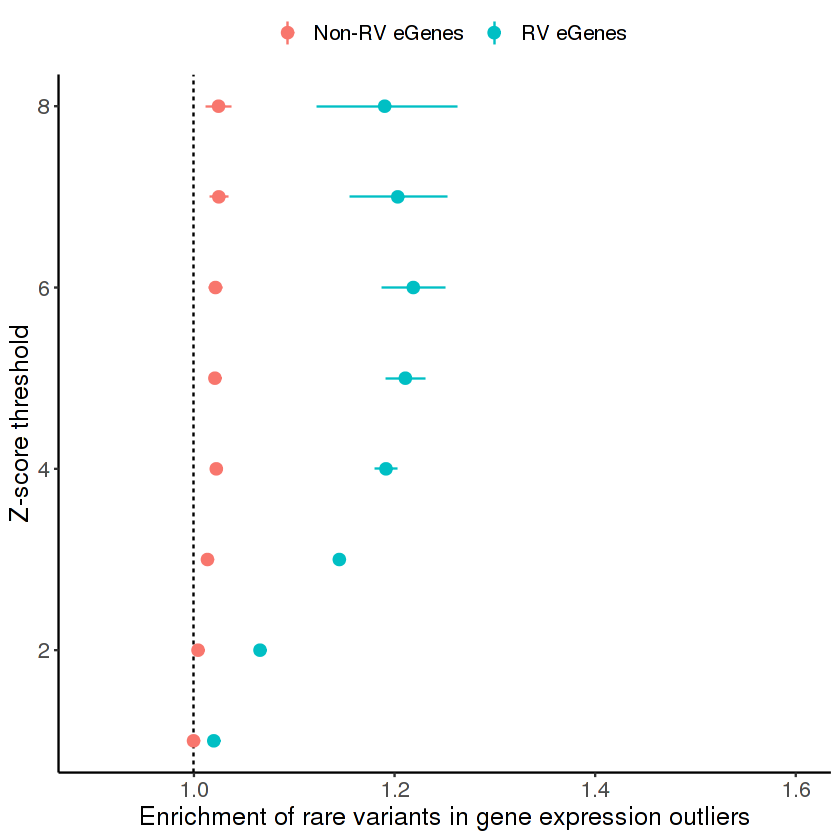

In [29]:
CairoPDF("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/rare.variant.enrichment.by.z.score.threshold.pdf")
temp = summary.outliers.enrichment
temp = temp[c(1:8, 11:18), ]
# temp$threshold = as.character(temp$threshold)
# temp$threshold = factor(temp$threshold, levels = temp$threshold)
p = ggplot(temp, aes(x = threshold, y = relative.risk)) +
theme_bw() + ylab('Enrichment of rare variants in gene expression outliers') + xlab("Z-score threshold") +
geom_abline(intercept = 1, slope = 0, linetype = "dashed") +
geom_pointrange(aes(x = threshold, ymin = min.ci, ymax = max.ci, colour = type)) +
# geom_text(aes(label = sprintf("%s (%s)", total.outliers, formatC(pval, digits = 2, format = "e"))), 
#           hjust = 0.05, vjust = -1) +
# geom_text(aes(label = sprintf("%s", 
#                               formatC(total.outliers / (total.outliers+total.controls), 
#                                       digits = 2, format = "e"))), 
#           hjust = 0.05, vjust = -1) + 
labs(color="") +
theme(panel.border = element_blank(), panel.grid.major = element_blank(),
      panel.grid.minor = element_blank(), legend.position = "top",
      axis.text.x = element_text(size = 13), text = element_text(size = 15),
      axis.text.y = element_text(size = 13),
      axis.line = element_line(colour = "black")) + coord_flip() + ylim(0.9, 1.6)

print(p)
dev.off()

### Number of outliers and outliers with rare variants

In [30]:
setwd("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary")

In [31]:
indiv.with.rare.var <- lapply(dir("indiv.with.rare.var.idx.non.rv.egenes.only/", 
                                  full.names = T), 
                              function(x) {try(fread(x), T)})
rare.z <- lapply(dir("log2.standardized.corrected.tpm.non.rv.egenes.only/", 
                     full.names = T), 
                 function(x) {try(fread(x), T)})

In [32]:
names(indiv.with.rare.var) <- tstrsplit(
    dir("indiv.with.rare.var.idx.non.rv.egenes.only/"), "\\.")[[8]]
names(rare.z) <- tstrsplit(
    dir("log2.standardized.corrected.tpm.non.rv.egenes.only/"), "\\.")[[8]]

In [33]:
get.outliers <- function(tpm, threshold = 2) {
    if (is.null(nrow(tpm))) {
        return(NULL)
    }
    tpm = tpm[, -1]
    tpm = t(scale(t(tpm)))
    outliers.idx = abs(tpm) > threshold
    num.total.outliers = rowSums(outliers.idx)
    return(num.total.outliers)
}

outliers.per.tissue.non.rv.egene2 <- lapply(rare.z, get.outliers)

In [34]:
rare.z2 <- lapply(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt",
                     full.names = T), 
                 function(x) {try(fread(x), T)})
names(rare.z2) <- tstrsplit(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt"), "\\.")[[8]]
outliers.per.tissue.rv.egene2 <- lapply(rare.z2, get.outliers)
outliers.per.tissue.rv.egene2 <- outliers.per.tissue.rv.egene2[!unlist(lapply(outliers.per.tissue.rv.egene2, is.null))]

In [35]:
outliers.per.tissue.non.rv.egene2 <- outliers.per.tissue.non.rv.egene2[match(names(outliers.per.tissue.rv.egene2), names(outliers.per.tissue.non.rv.egene2))]

In [36]:
t.test(unlist(outliers.per.tissue.rv.egene2), unlist(outliers.per.tissue.non.rv.egene2), alternative = "greater")


	Welch Two Sample t-test

data:  unlist(outliers.per.tissue.rv.egene2) and unlist(outliers.per.tissue.non.rv.egene2)
t = 151.66, df = 20100, p-value < 2.2e-16
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 6.175025      Inf
sample estimates:
mean of x mean of y 
 19.52387  13.28113 


In [37]:
mean(unlist(outliers.per.tissue.rv.egene2))
length(unlist(outliers.per.tissue.rv.egene2))
mean(unlist(outliers.per.tissue.non.rv.egene2))
length(unlist(outliers.per.tissue.non.rv.egene2))

[1] 19.52387

[1] 19064

[1] 13.28113

[1] 888304

In [38]:
get.outliers.per.tissue <- function(tpm, rare.idx, threshold = 2) {
  result = data.frame()
  for (tissue in names(rare.idx)) {
    sample.tpm = tpm[[tissue]]
    if (!any(class(sample.tpm) == "data.frame")) {
      result = rbind(result, rep(NA, ncol(result)))
      next()
    }
    sample.rare = rare.idx[[tissue]]
    selected.gene.idx = match(sample.tpm$gene, sample.rare$gene)
    selected.gene = sample.tpm$gene
    sample.tpm = sample.tpm[, -1]
    sample.rare = sample.rare[selected.gene.idx, -1]
    sample.tpm = t(scale(t(sample.tpm)))

    outliers.idx = abs(sample.tpm) > threshold
    rare.outliers.idx = outliers.idx & sample.rare
    common.outliers.idx = outliers.idx & (!sample.rare)
    rare.controls.idx = (!outliers.idx) & sample.rare
    common.controls.idx = (!outliers.idx) & (!sample.rare)

    num.total.outliers = rowSums(outliers.idx)
    num.total.controls = rowSums(!outliers.idx)
    num.common.outliers = rowSums(common.outliers.idx)
    num.common.controls = rowSums(common.controls.idx)
    num.rare.outliers = rowSums(rare.outliers.idx)
    num.rare.controls = rowSums(rare.controls.idx)
    prop.rare.outliers = num.rare.outliers / num.total.outliers
    result = rbind(result, 
                   c(
                     mean(num.total.outliers), 
                     sd(num.total.outliers) / sqrt(length(num.total.outliers)),
                     mean(num.total.controls),
                     sd(num.total.controls) / sqrt(length(num.total.controls)),
                     mean(num.rare.outliers), 
                     sd(num.rare.outliers) / sqrt(length(num.rare.outliers)),
                     mean(num.rare.controls),
                     sd(num.rare.controls) / sqrt(length(num.rare.controls)),
                     mean(num.common.outliers), 
                     sd(num.common.outliers) / sqrt(length(num.common.outliers)),
                     mean(num.common.controls),
                     sd(num.common.controls) / sqrt(length(num.common.controls)),
                     mean(prop.rare.outliers, na.rm=T),
                     sd(prop.rare.outliers, na.rm=T) / sqrt(length(prop.rare.outliers[!is.na(prop.rare.outliers)])),
                       sum(num.total.outliers, na.rm=T),
                       sum(num.total.controls, na.rm=T),
                       sum(num.common.outliers, na.rm=T),
                       sum(num.common.controls, na.rm=T),
                       sum(num.rare.outliers, na.rm=T),
                       sum(num.rare.controls, na.rm=T),
                       num.genes = length(num.total.outliers[!is.na(num.total.outliers)])
                   )
    )
      
  }
  colnames(result) = c(
    "mean.total.outliers", "se.total.outliers", 
    "mean.total.controls", "se.total.controls", 
    "mean.rare.outliers", "se.rare.outliers",
    "mean.rare.controls", "se.rare.controls",
    "mean.common.outliers", "se.common.outliers",
    "mean.common.controls", "se.common.controls",
    "mean.prop.rare.outliers", "se.prop.rare.outliers",
      "num.total.outliers", "num.total.controls",
      "num.common.outliers", "num.common.controls",
      "num.rare.outliers", "num.rare.controls", "num.genes"
  )
  result$tissue = names(rare.idx)
  return(result)
}

In [39]:
indiv.with.rare.var <- lapply(dir("indiv.with.rare.var.idx.non.rv.egenes.only/", 
                                  full.names = T), 
                              function(x) {try(fread(x), T)})
rare.z <- lapply(dir("log2.standardized.corrected.tpm.non.rv.egenes.only/", 
                     full.names = T), 
                 function(x) {try(fread(x), T)})

In [40]:
names(indiv.with.rare.var) <- tstrsplit(
    dir("indiv.with.rare.var.idx.non.rv.egenes.only/"), "\\.")[[8]]
names(rare.z) <- tstrsplit(
    dir("log2.standardized.corrected.tpm.non.rv.egenes.only/"), "\\.")[[8]]

In [41]:
indiv.with.rare.var2 <- lapply(dir("indiv.with.rare.var.idx.rv.egenes.only/", 
                                  full.names = T), 
                              function(x) {try(fread(x), T)})
rare.z2 <- lapply(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt",
                     full.names = T), 
                 function(x) {try(fread(x), T)})

In [42]:
names(indiv.with.rare.var2) <- tstrsplit(dir("indiv.with.rare.var.idx.rv.egenes.only/"), "\\.")[[7]]
names(rare.z2) <- tstrsplit(dir("log2.standardized.corrected.tpm.rv.egenes.only/", pattern = "lrt"), "\\.")[[8]]

In [43]:
outliers.per.tissue.non.rv.egene = get.outliers.per.tissue(rare.z, indiv.with.rare.var)
outliers.per.tissue.rv.egene = get.outliers.per.tissue(rare.z2, indiv.with.rare.var2)

In [44]:
head(outliers.per.tissue.rv.egene$met)

NULL

In [45]:
outliers.per.tissue.rv.egene %>% 
    pull(mean.total.outliers) %>% mean(na.rm=T)
outliers.per.tissue.non.rv.egene %>% 
    pull(mean.total.outliers) %>% mean(na.rm=T)
outliers.per.tissue.rv.egene %>% 
    pull(mean.total.outliers) %>% median(na.rm = T)
outliers.per.tissue.non.rv.egene %>% 
    pull(mean.total.outliers) %>% median(na.rm = T)

[1] 13.65509

[1] 11.66779

[1] 12.27151

[1] 9.080417

In [46]:
idx = match(outliers.per.tissue.rv.egene$tissue, outliers.per.tissue.non.rv.egene$tissue)
t.test(outliers.per.tissue.rv.egene$mean.total.outliers, outliers.per.tissue.non.rv.egene$mean.total.outliers[idx], paired = T, alternative = "greater")


	Paired t-test

data:  outliers.per.tissue.rv.egene$mean.total.outliers and outliers.per.tissue.non.rv.egene$mean.total.outliers[idx]
t = 1.6958, df = 37, p-value = 0.04917
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 0.0005371531          Inf
sample estimates:
mean of the differences 
              0.1051873 


In [47]:
outliers.per.tissue.rv.egene = na.omit(outliers.per.tissue.rv.egene)

In [48]:
outliers.per.tissue.non.rv.egene %>% 
    filter(tissue %in% outliers.per.tissue.rv.egene$tissue) -> outliers.per.tissue.non.rv.egene

In [49]:
outliers.per.tissue.rv.egene$type = "RV eGenes"
outliers.per.tissue.non.rv.egene$type = "Other Genes"
df = rbind(outliers.per.tissue.rv.egene, outliers.per.tissue.non.rv.egene)

png 
  2

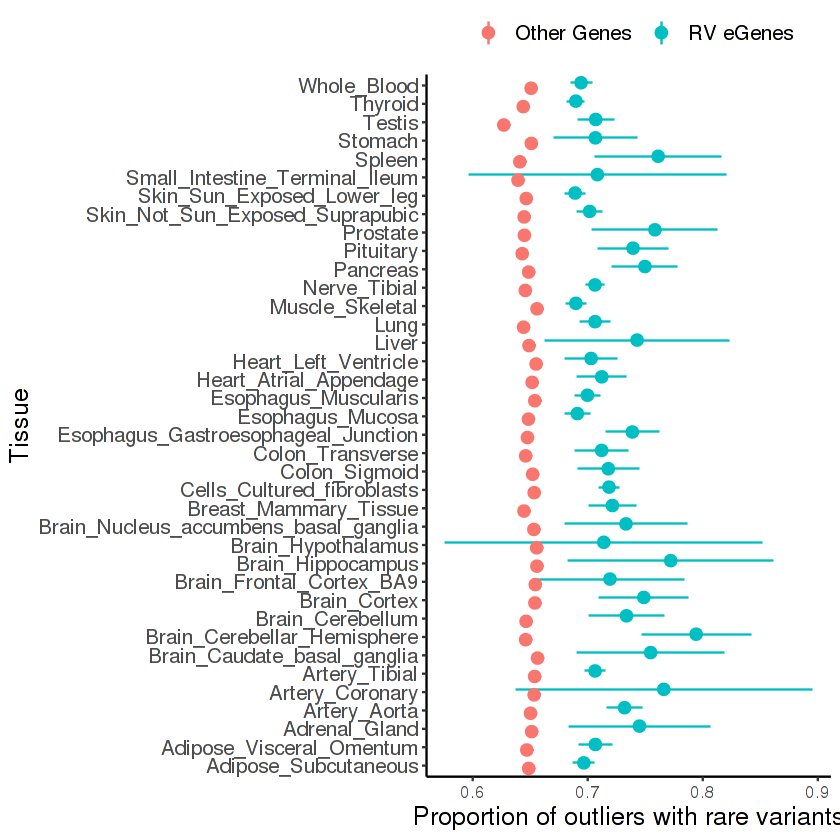

In [50]:
CairoPDF("/u/project/eeskin2/k8688933/rare_var/results/tss_20k_v8/result_summary/enrichment/outliers.prop.by.total.outliers.per.tissue.lrt.only.pdf",
         width = 12, height = 14)
p <- ggplot(na.omit(df) %>% arrange(mean.prop.rare.outliers) , 
            aes(x=tissue, y=mean.prop.rare.outliers, colour=tissue)) + 
  geom_pointrange(aes(x = tissue, ymin = mean.prop.rare.outliers + 1.96 * se.prop.rare.outliers, 
                      ymax = mean.prop.rare.outliers - 1.96 * se.prop.rare.outliers, 
                      colour = type), 
                  position = position_dodge(width = 0.6)) +
  ylab("Proportion of outliers with rare variants") + theme_bw() +
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), 
        axis.text.x = element_text(size = 10),
        axis.line = element_line(colour = "black"),
        text = element_text(size = 15), 
        legend.position = "top") + xlab("Tissue") + coord_flip() + labs(color="")
# ggtitle("Outliers carrying rare variants in RV eGenes")
print(p)
dev.off()